In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
import os
int = np.vectorize(int)
from copy import deepcopy as copy

In [2]:
NTURN = np.array([128,256,512,1024,2048])
nBatch = 32

NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
print(betx,alfx)

1.9065054393933862 1.4082261727304293


In [5]:
def getTBT(iBatch):
    iTBT = {}
    TBT = {}
    X = {}
    Y = {}
    Npt = {}

    for nturn in NTURN[:-1]:
        os.chdir('./'+str(nturn))
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn+iBatch,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])
        iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn+iBatch,ke,mass,freq)
        TBT[-nturn] = TBT[-nturn][:,:4,:]
        Npt[-nturn] = len(iTBT[-nturn])
        os.chdir('../')
    nturn = NTURN[-1]
    os.chdir('./'+str(nturn))
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn+iBatch,ke,mass,freq)
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])
    os.chdir('../')
        
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)

        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            X[nturn][iturn:jturn] = tmp[:,0,:] - 1j*tmp[:,1,:]
            Y[nturn][iturn:jturn] = tmp[:,2,:] - 1j*tmp[:,3,:]
            iturn = jturn

        for i in range(len(NTURN)-1):
            nturn = NTURN[i]
            npt = len(iTBT[-nturn])
            X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
            Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
            tmp = TBT[-nturn][::-1,:4,:]
            X[-nturn]=tmp[:,0,:] - 1j*tmp[:,1,:]
            Y[-nturn]=tmp[:,2,:] - 1j*tmp[:,3,:]

            iturn = 0
            for j in range(i+1):
                jturn = NTURN[j]
                itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
                tmp = TBT[jturn][:,:,itmp]
                X[nturn][iturn:jturn] = tmp[:,0,:] - 1j*tmp[:,1,:]
                Y[nturn][iturn:jturn] = tmp[:,2,:] - 1j*tmp[:,3,:]
                iturn = jturn
    return X,Y

In [6]:
def getDiffMultiTurns(X,Y):
    Xdiff = {}
    Ydiff = {}
    Adiff = {}

    for nturn in NTURN[:-1]:
        Xdiff = np.sum(np.abs(X[nturn]-X[-nturn])**2,0)
        Ydiff = np.sum(np.abs(Y[nturn]-Y[-nturn])**2,0)
        Adiff[nturn] = np.sqrt((Xdiff + Ydiff)/nturn)
        Adiff[nturn] = np.log10(Adiff[nturn])

    return Adiff

In [7]:
def reduceX_to_initial(X):
    for k,v in X.items():
        X[k] = np.real(X[k][0,:])

def concantenate_batches(fin,fout):
    for k,v in fout.items():
        fout[k] = np.concatenate((v, fin[k]), axis=None)

In [8]:
for i in range(nBatch):
    X_,Y_ = getTBT(i+1)
    if i==0:
        for n in NTURN:
            print(n,X_[n].shape)
            nturn = 256
            iturn = 126
            ipt = 100
            print(X_[nturn][iturn,ipt]-X_[-nturn][iturn,ipt])
            
    Diff_ = getDiffMultiTurns(X_,Y_)
    reduceX_to_initial(X_)
    reduceX_to_initial(Y_)
    if(i==0):
        X   = X_.copy()
        Y   = Y_.copy()
        Diff= Diff_.copy()
    else:
        concantenate_batches(X_,X)
        concantenate_batches(Y_,Y)
        concantenate_batches(Diff_,Diff)

128 (128, 16005)
(-2.566146947713399e-12-6.106410407706597e-12j)
256 (256, 16005)
(-2.566146947713399e-12-6.106410407706597e-12j)
512 (512, 16005)
(-2.566146947713399e-12-6.106410407706597e-12j)
1024 (1024, 16005)
(-2.566146947713399e-12-6.106410407706597e-12j)
2048 (2048, 16005)
(-2.566146947713399e-12-6.106410407706597e-12j)


In [9]:
n=128
xmax = np.max(np.abs(X[n]))
ymax = np.max(np.abs(Y[n]))

nx = 48  #Must be even number to have x=0 an grid point
ny = 48

dx = 2*xmax/nx
dy = 2*ymax/ny

xMsh = np.linspace(-xmax-dx,xmax+dx, nx+3)
yMsh = np.linspace(-ymax-dy,ymax+dy, ny+3)

In [10]:
X.keys()

dict_keys([128, -128, 256, -256, 512, -512, 1024, -1024, 2048])

In [11]:
def getMeshInfo(X,Y,xMsh,yMsh,dx,dy):
    nx=len(xMsh)
    ny=len(yMsh)
    gZ = np.zeros([nx,ny])
    gN = np.zeros([nx,ny])
    fX,fY = (X+xmax+dx)/dx, (Y+ymax+dy)/dy
    iX,iY = int(fX), int(fY)
    fX,fY = fX-iX, fY-iY
    iX,iY = iX, iY
    
    for i in range(len(X)):
        gZ[iX[i]  ,iY[i]  ] = gZ[iX[i]  ,iY[i]  ] +Diff[n][i]*(1.0-fY[i])*(1.0-fX[i])
        gZ[iX[i]  ,iY[i]+1] = gZ[iX[i]  ,iY[i]+1] +Diff[n][i]*(    fY[i])*(1.0-fX[i])
        gZ[iX[i]+1,iY[i]+1] = gZ[iX[i]+1,iY[i]+1] +Diff[n][i]*(    fY[i])*(    fX[i])
        gZ[iX[i]+1,iY[i]  ] = gZ[iX[i]+1,iY[i]  ] +Diff[n][i]*(1.0-fY[i])*(    fX[i])
        gN[iX[i]  ,iY[i]  ] = gN[iX[i]  ,iY[i]  ] +           (1.0-fY[i])*(1.0-fX[i])
        gN[iX[i]  ,iY[i]+1] = gN[iX[i]  ,iY[i]+1] +           (    fY[i])*(1.0-fX[i])
        gN[iX[i]+1,iY[i]+1] = gN[iX[i]+1,iY[i]+1] +           (    fY[i])*(    fX[i])
        gN[iX[i]+1,iY[i]  ] = gN[iX[i]+1,iY[i]  ] +           (1.0-fY[i])*(    fX[i])
        
    for i in range(1,int(ny/2)):
        gZ[:,int(ny/2)-i]=gZ[:,int(ny/2)+i]
        gN[:,int(ny/2)-i]=gN[:,int(ny/2)+i]

    gN[:,int(ny/2)]=2*gN[:,int(ny/2)]
    gZ[:,int(ny/2)]=2*gZ[:,int(ny/2)]


#     args = np.argwhere(gN>0.1)
#     gZ[args] = gZ[args]/gN[args]        
    return gZ,gN

In [12]:
def msh2p(xlist,ylist,gZ,gN):
    ny,nx = gN.shape
    pX = np.zeros(nx*ny)
    pY = np.zeros(nx*ny)
    pZ = np.zeros(nx*ny)
    n=0
    for ix in range(nx):
        for iy in range(ny):
            if gN[ix,iy]>0.1:
                pX[n] = xlist[ix]
                pY[n] = ylist[iy]
                pZ[n] = gZ[ix,iy]/gN[ix,iy]
#                 pZ[n] = gN[ix,iy]
                n=n+1
    pX=pX[:n]
    pY=pY[:n]
    pZ=pZ[:n]
    return pX,pY,pZ

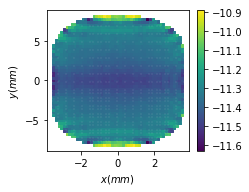

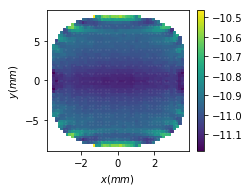

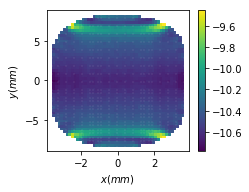

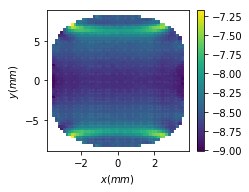

In [15]:
for n in NTURN[:-1]:
    gZ,gN = getMeshInfo(X[n],Y[n],xMsh,yMsh,dx,dy)
    pX,pY,pZ = msh2p(xMsh,yMsh,gZ,gN)
    plt.figure(figsize=[3.53,2.78])
    f1=plt.scatter(pX*1.0e3,pY*1.0e3,c=pZ,s=5,marker='s')
    plt.xlim(-xmax*1.1e3,xmax*1.1e3)
    plt.ylim(-ymax*1.1e3,ymax*1.1e3)
    plt.xlabel('$x (mm)$')
    plt.ylabel('$y (mm)$')
    plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('FB.DA.4Dto2D.turn='+str(n)+'.png',dpi=180)